In [ ]:
import warnings
import os
import sys
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

try:
    from data_processing import DataProcessor
    from model_evaluation import evaluate_model
except ImportError:
    if '__file__' in globals():
        script_dir = os.path.dirname(os.path.abspath(__file__))
        if os.path.basename(script_dir) == 'src':
            project_root = os.path.dirname(script_dir)
        else:
            project_root = script_dir
    else:
        current_dir = os.getcwd()
        project_root = os.path.dirname(current_dir) if current_dir.endswith('notebooks') else current_dir
    
    src_dir = os.path.join(project_root, 'src')
    if src_dir not in sys.path:
        sys.path.append(src_dir)
    
    from data_processing import DataProcessor
    from model_evaluation import evaluate_model

if '__file__' in globals():
    script_dir = os.path.dirname(os.path.abspath(__file__))
    if os.path.basename(script_dir) == 'src':
        project_root = os.path.dirname(script_dir)
    else:
        project_root = script_dir
else:
    current_dir = os.getcwd()
    project_root = os.path.dirname(current_dir) if current_dir.endswith('notebooks') else current_dir

data_dir = os.path.join(project_root, 'data')

cic_pkl_file_name = os.path.join(data_dir, "cic_dataframe.pkl")
cic_file_paths = [
    os.path.join(data_dir, f"CIC/nfstream/{day}-WorkingHours.pcap_nfstream_labeled.csv")
    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
]

tcpdump_pkl_file_name = os.path.join(data_dir, "tcpdump_dataframe.pkl")
tcpdump_file_paths = [
    os.path.join(data_dir, f"tcpdump/nfstream/{filename}_labeled.csv")
    for filename in [
        "normal_01",
        "normal_02",
        "normal_and_attack_01",
        "normal_and_attack_02",
        "normal_and_attack_03",
        "normal_and_attack_04",
        "normal_and_attack_05",
    ]
]

# Constants
NORMAL_LABEL = 1
ANOMALY_LABEL = -1

# Configuration
test_size = 0.2
random_state = 42
scaled = False
encode_categorical = True
shap_enabled = True
dev_mode = False
corr_threshold = 0.95

In [2]:
# 1. Load and prepare the data
print("\nStep 1: Load and prepare the data")
if os.path.exists(cic_pkl_file_name):
    print(f"Loading dataframe from {cic_pkl_file_name}")
    dataframe = pd.read_pickle(cic_pkl_file_name)
else:
    print(f"Creating dataframe from pcap files and saving to {cic_pkl_file_name}")
    dataframe = DataProcessor.get_dataframe(file_paths=cic_file_paths)
    dataframe.to_pickle(cic_pkl_file_name)

# Add new featueres:
print("Adding new features to the dataframe")
dataframe = DataProcessor.add_new_features(dataframe)

# Drop object columns and handle categorical data
print("Dropping object columns except for some categorical columns")
df_without_object, available_categorical = DataProcessor.drop_object_columns(
            dataframe, encode_categorical=encode_categorical
        )

# Split into features and labels
print("Splitting data into features (X) and labels (y)")
X, y = DataProcessor.split_to_X_y(df_without_object)

# Clean the data
print("Cleaning data")
DataProcessor.clean_data(X)

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

# Split the data into training and test sets
print(f"Splitting data into train and test sets with test_size={test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

# Handle categorical encoding
print("Handling categorical encoding")
X_train, X_test, categorical_encoder = (
    DataProcessor.one_hot_encode_categorical(
        X_train, X_test, available_categorical, None
    )
)

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

# Scaling the data
if scaled:
    print("Scaleing the data")
    scaler = MinMaxScaler()
    print("New MinMaxScaler instance created")
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index,
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index,
    )
else:
    scaler = None

# Label conversion
print("Converting labels: benign to 1 and anomalous to -1")
y_train = y_train.map(lambda x: 1 if x == "benign" else -1)
y_test = y_test.map(lambda x: 1 if x == "benign" else -1)

# Feature selection
features_to_drop = DataProcessor.get_features_to_drop()
print(f"Always drop id, src, timestamp...: {features_to_drop}")
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)
print(f"Droped {len(features_to_drop)} features")

# Remove highly correlated features
print(f"Dropping highly correlated features with threshold={corr_threshold}")
X_train, dropped_corr = DataProcessor.remove_highly_correlated_features(X_train, threshold=corr_threshold)
X_test = X_test.drop(columns=dropped_corr)
print(f"Droped {len(dropped_corr)} features: {dropped_corr}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

# reset index to ensure consistent indexing
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


Step 1: Load and prepare the data
Loading dataframe from /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/data/cic_dataframe.pkl
Adding new features to the dataframe
flow rate (bytes/sec and packets/sec)
packet rate (bytes/sec and packets/sec)
Down/Up Ratio
Dropping object columns except for some categorical columns
Retaining categorical features for encoding: ['application_name', 'application_category_name']
Number of columns before dropping object columns: 92
Dropped object columns (11): ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type']
Number of columns after dropping object columns: 81
Splitting data into features (X) and labels (y)
Cleaning data
X.shape: (2916222, 80)
y.shape: (2916222,)
Splitting data into train and test sets with test_size=0.2
Handling categorical encoding
Processing categorical features: ['application


Step 2: Feature Selection using Random Forest Classifier
Total features: 307
Random Forest with 100 trees trained

Top 20 most important features:
                       feature  importance
12     bidirectional_stddev_ps    0.084748
33   bidirectional_rst_packets    0.083522
9                dst2src_bytes    0.071479
11       bidirectional_mean_ps    0.050756
1                     dst_port    0.050579
43         dst2src_rst_packets    0.038378
46      application_confidence    0.032124
8                src2dst_bytes    0.031562
7        bidirectional_packets    0.030574
47          flow_bytes_per_sec    0.029129
281   application_name_Unknown    0.027939
32   bidirectional_psh_packets    0.027555
37         src2dst_rst_packets    0.027199
137      application_name_HTTP    0.027083
217       application_name_TLS    0.026072
28   bidirectional_syn_packets    0.025665
49     src2dst_packets_per_sec    0.021941
16              dst2src_min_ps    0.020947
2                     protocol    0

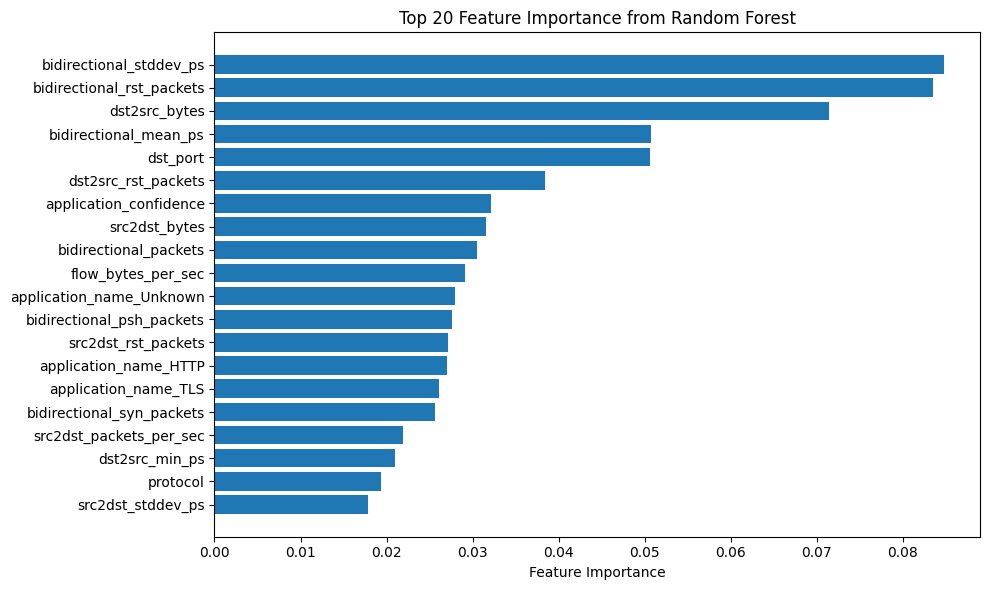

In [3]:
# 2. Feature Selection
print("\nStep 2: Feature Selection using Random Forest Classifier")

rfc_selector = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=random_state,
    n_jobs=-1
)

rfc_selector.fit(X_train, y_train)

# Feature Importance Extraction
feature_importance = rfc_selector.feature_importances_
feature_names = X_train.columns
# sort features by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Total features: {len(feature_names)}")
print(f"Random Forest with {rfc_selector.n_estimators} trees trained")
print("\nTop 20 most important features:")
print(importance_df.head(20))

# visualize feature importance
plt.figure(figsize=(10, 6))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show(block=False)


Step 3: Performance evaluation with different feature counts

Validating with 5 features
  F1: 0.9678, Normal Det.: 0.9966, Anomaly Det.: 0.9546, Outlier: 0.1558

Validating with 10 features
  F1: 0.9611, Normal Det.: 0.9956, Anomaly Det.: 0.9464, Outlier: 0.1553

Validating with 15 features
  F1: 0.9613, Normal Det.: 0.9968, Anomaly Det.: 0.9413, Outlier: 0.1535

Validating with 20 features
  F1: 0.9654, Normal Det.: 0.9967, Anomaly Det.: 0.9495, Outlier: 0.1549

Validating with 25 features
  F1: 0.9711, Normal Det.: 0.9967, Anomaly Det.: 0.9603, Outlier: 0.1567

Validating with 30 features
  F1: 0.9738, Normal Det.: 0.9965, Anomaly Det.: 0.9664, Outlier: 0.1578

Validating with 35 features
  F1: 0.9733, Normal Det.: 0.9967, Anomaly Det.: 0.9645, Outlier: 0.1573

Validating with 40 features
  F1: 0.9688, Normal Det.: 0.9963, Anomaly Det.: 0.9575, Outlier: 0.1565

Validating with 45 features
  F1: 0.9760, Normal Det.: 0.9971, Anomaly Det.: 0.9678, Outlier: 0.1575

Validating with 50 f

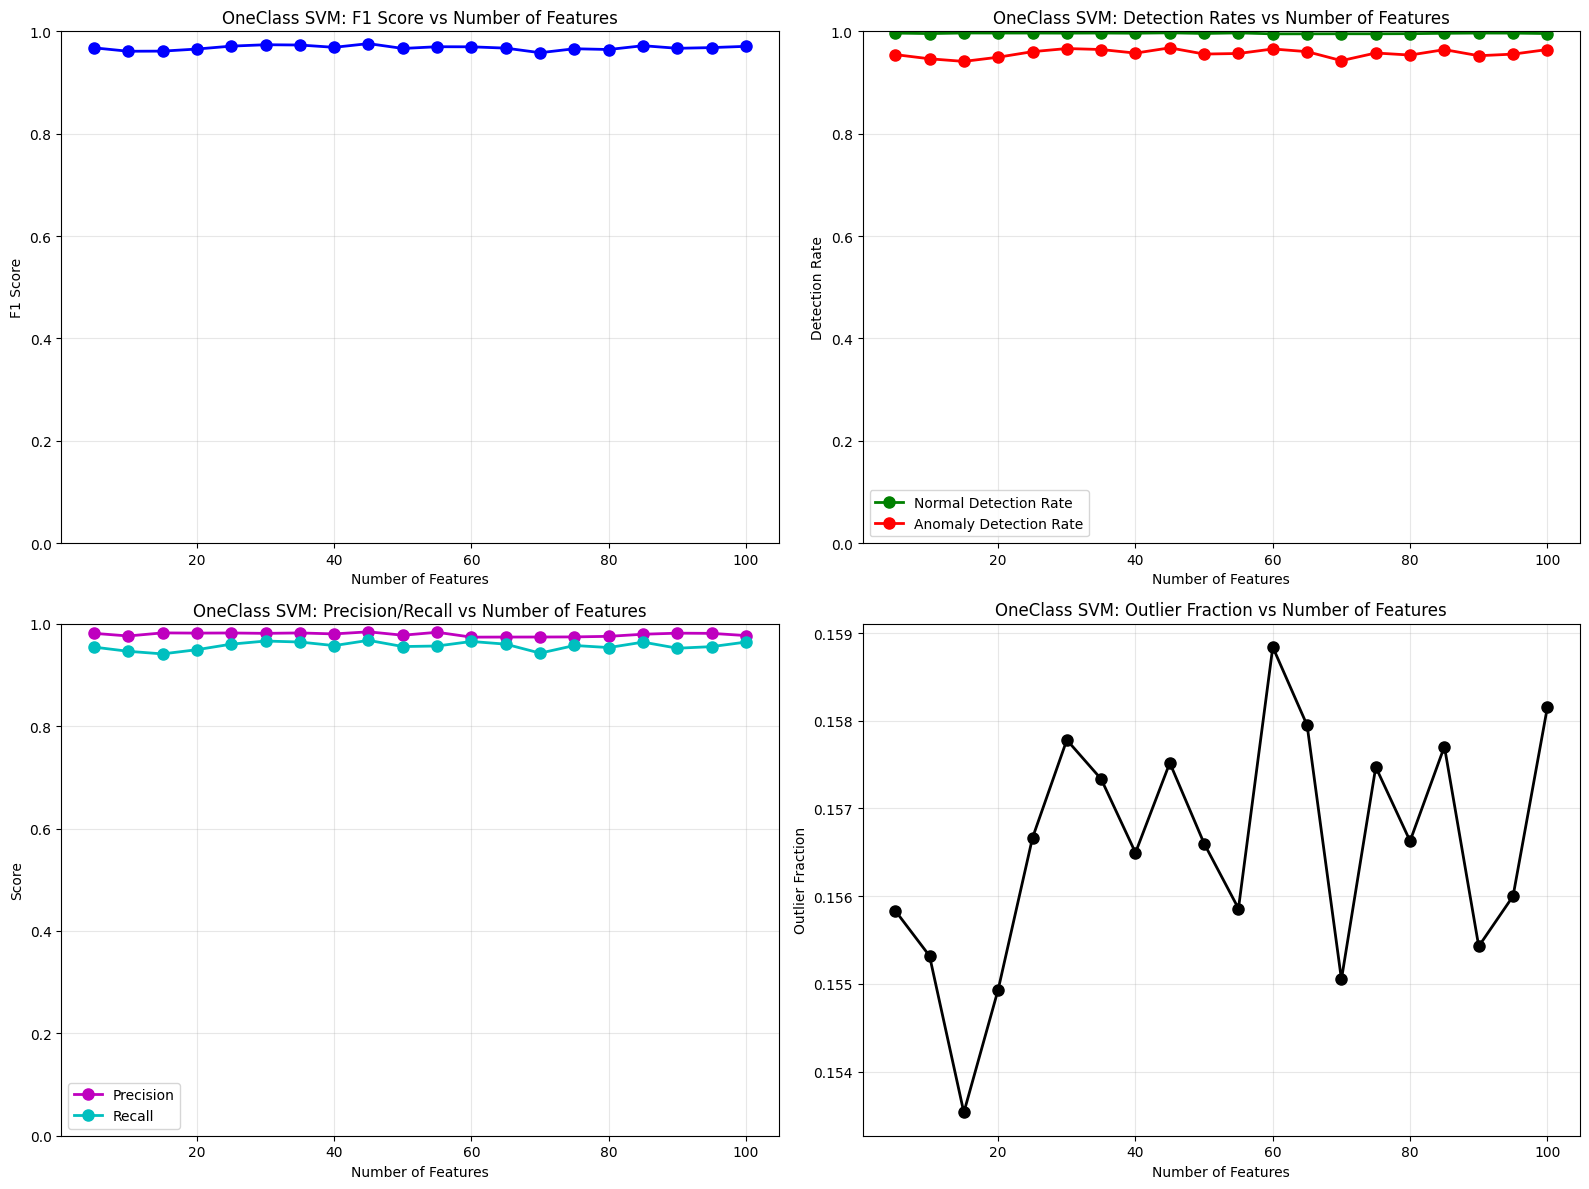

Optimal feature selection
Optimal number of features: 45
F1 Score: 0.9760
Normal Detection Rate: 0.9971
Anomaly Detection Rate: 0.9678
Balanced Score: 0.9803
Outlier Fraction: 0.1575

Selected features for OneClass SVM:
 1. bidirectional_stddev_ps             0.0847
 2. bidirectional_rst_packets           0.0835
 3. dst2src_bytes                       0.0715
 4. bidirectional_mean_ps               0.0508
 5. dst_port                            0.0506
 6. dst2src_rst_packets                 0.0384
 7. application_confidence              0.0321
 8. src2dst_bytes                       0.0316
 9. bidirectional_packets               0.0306
10. flow_bytes_per_sec                  0.0291
11. application_name_Unknown            0.0279
12. bidirectional_psh_packets           0.0276
13. src2dst_rst_packets                 0.0272
14. application_name_HTTP               0.0271
15. application_name_TLS                0.0261
16. bidirectional_syn_packets           0.0257
17. src2dst_packets_per_sec 

In [4]:
# 3. Performance validation with different feature counts
print("\nStep 3: Performance evaluation with different feature counts")
if dev_mode:
    target_features_list = [5, 10]
else:
    target_features_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
results_comparison = []

for n_features in target_features_list:
    print(f"\nValidating with {n_features} features")

    # select top n_features based on F-scores
    top_features = importance_df.head(n_features)['feature'].tolist()
    
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y_train
    )

    X_train_split_selected = X_train_split[top_features]
    X_val_split_selected = X_val_split[top_features]

    # Validate model for selected features
    try:
        test_rf = RandomForestClassifier(
            n_estimators=20,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=random_state,
        )
        
        test_rf.fit(X_train_split_selected, y_train_split)

        y_pred_val = test_rf.predict(X_val_split_selected)

        y_true_binary = (y_val_split != NORMAL_LABEL).astype(int)  # normal: 0, anomaly: 1
        y_pred_binary = (y_pred_val != NORMAL_LABEL).astype(int)   # normal: 0, anomaly: 1

        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        # Normal and anomaly detection rates
        normal_total = np.sum(y_true_binary == 0)
        anomaly_total = np.sum(y_true_binary == 1)
        
        if normal_total > 0:
            normal_detection_rate = np.sum((y_true_binary == 0) & (y_pred_binary == 0)) / normal_total
        else:
            normal_detection_rate = 0.0
            
        if anomaly_total > 0:
            anomaly_detection_rate = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / anomaly_total
        else:
            anomaly_detection_rate = 0.0
        
        # outlier fraction
        outlier_fraction = np.sum(y_pred_val == -1) / len(y_pred_val)

        results_comparison.append({
            'n_features': n_features,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'normal_detection_rate': normal_detection_rate,
            'anomaly_detection_rate': anomaly_detection_rate,
            'outlier_fraction': outlier_fraction
        })

        print(f"  F1: {f1:.4f}, Normal Det.: {normal_detection_rate:.4f}, "
            f"Anomaly Det.: {anomaly_detection_rate:.4f}, Outlier: {outlier_fraction:.4f}")

    except Exception as e:
        print(f"  Error: {e}")
        results_comparison.append({
            'n_features': n_features,
            'precision': 0.0, 
            'recall': 0.0, 
            'f1_score': 0.0,
            'normal_detection_rate': 0.0, 
            'anomaly_detection_rate': 0.0,
            'outlier_fraction': 0.0, 'training_samples': 0
        })

print(f"\nCompleted evaluation for {len(results_comparison)} feature configurations.")

# isualization and analysis
print("Results visualization")

results_df = pd.DataFrame(results_comparison)
print("\nResults Summary:")
print(results_df.round(4))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score
ax1.plot(results_df['n_features'], results_df['f1_score'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('F1 Score')
ax1.set_title('OneClass SVM: F1 Score vs Number of Features')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Detection Rates
ax2.plot(results_df['n_features'], results_df['normal_detection_rate'], 'go-', 
         label='Normal Detection Rate', linewidth=2, markersize=8)
ax2.plot(results_df['n_features'], results_df['anomaly_detection_rate'], 'ro-', 
         label='Anomaly Detection Rate', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Detection Rate')
ax2.set_title('OneClass SVM: Detection Rates vs Number of Features')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Precision vs Recall
ax3.plot(results_df['n_features'], results_df['precision'], 'mo-', 
         label='Precision', linewidth=2, markersize=8)
ax3.plot(results_df['n_features'], results_df['recall'], 'co-', 
         label='Recall', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Features')
ax3.set_ylabel('Score')
ax3.set_title('OneClass SVM: Precision/Recall vs Number of Features')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Outlier Fraction
ax4.plot(results_df['n_features'], results_df['outlier_fraction'], 'ko-', 
         linewidth=2, markersize=8)
ax4.set_xlabel('Number of Features')
ax4.set_ylabel('Outlier Fraction')
ax4.set_title('OneClass SVM: Outlier Fraction vs Number of Features')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show(block=False)

print("Optimal feature selection")

# Calculate balanced score
results_df['balanced_score'] = (
    results_df['f1_score'] + 
    results_df['normal_detection_rate'] + 
    results_df['anomaly_detection_rate']
) / 3

# NaN values handling
valid_results = results_df[results_df['balanced_score'] > 0]

if len(valid_results) > 0:
    best_idx = valid_results['balanced_score'].idxmax()
    best_result = valid_results.loc[best_idx]
    
    optimal_n_features = int(best_result['n_features'])
    optimal_features_list = importance_df.head(optimal_n_features)['feature'].tolist()
    
    print(f"Optimal number of features: {optimal_n_features}")
    print(f"F1 Score: {best_result['f1_score']:.4f}")
    print(f"Normal Detection Rate: {best_result['normal_detection_rate']:.4f}")
    print(f"Anomaly Detection Rate: {best_result['anomaly_detection_rate']:.4f}")
    print(f"Balanced Score: {best_result['balanced_score']:.4f}")
    print(f"Outlier Fraction: {best_result['outlier_fraction']:.4f}")
    
    print("\nSelected features for OneClass SVM:")
    for i, (_, row) in enumerate(importance_df.head(optimal_n_features).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<35} {row['importance']:.4f}")
        
X_train_optimal = X_train[optimal_features_list]
X_test_optimal = X_test[optimal_features_list]

print(f"\nX_train_optimal.shape: {X_train_optimal.shape}")
print(f"X_test_optimal.shape: {X_test_optimal.shape}")

In [5]:
# 4. Hyperparameter tuning 
print("\nStep 4: Hyperparameter Tuning using Grid Search")

def tune_hyperparameters(X_train, y_train, dev_mode=False):
    if dev_mode:
        param_grid = {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5],
            'min_samples_leaf': [2],
            'max_features': ['sqrt'],
            'random_state': [random_state]
        }
        cv = 2
    else:
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2'],
            'random_state': [random_state]
        }
        cv = 3

    rf_tuner = RandomForestClassifier()
    grid_search = GridSearchCV(
        rf_tuner,
        param_grid,
        scoring='f1_weighted',
        cv=cv,
        verbose=2,
        n_jobs=-1
    )

    total_combinations = 1
    for param_values in param_grid.values():
        total_combinations *= len(param_values)
    
    print(f"Testing {total_combinations} parameter combinations...")
    start_time = time.time()
    
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"Grid search completed in {end_time - start_time:.2f} seconds")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Hyperparameter tuning
best_rf_model = tune_hyperparameters(X_train_optimal, y_train, dev_mode=dev_mode)


Step 4: Hyperparameter Tuning using Grid Search
Testing 48 parameter combinations...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42; total time=  57.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=42; total time=  59.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=42; total time=  59.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42; total time=  59.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42; total time= 1.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42; total time= 1.1min
[CV] END max_depth=5, max_features=sqrt, m


Step 5: Final Random Forest Classifier model training and evaluation
Best Random Forest model with parameters: n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, random_state=42
Training the Random Forest model with optimal features...
Model trained successfully.
using predict_proba for prediction scores

Test Data - BENIGN Count: 489792, Ratio: 83.98%
Test Data - ANOMALOUS Count: 93453, Ratio: 16.02%

Test result:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    489792
   ANOMALOUS       0.99      0.99      0.99     93453

    accuracy                           1.00    583245
   macro avg       0.99      0.99      0.99    583245
weighted avg       1.00      1.00      1.00    583245

[[488572   1220]
 [   833  92620]]
Precision: 0.987
Recall: 0.991
False Positive Rate: 0.002
False Negative Rate: 0.009
F1-Score: 0.989
Area under the curve: 1.000


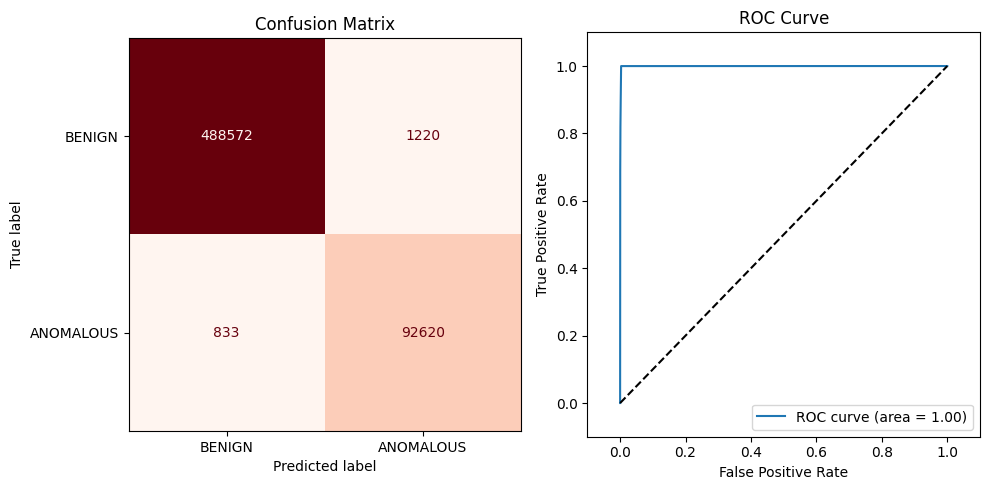

In [6]:
# 5. Final Random Forest Classifier  model training and evaluation
print("\nStep 5: Final Random Forest Classifier model training and evaluation")
max_depth = best_rf_model.get_params()['max_depth']
max_features = best_rf_model.get_params()['max_features']
min_samples_leaf = best_rf_model.get_params()['min_samples_leaf']
min_samples_split = best_rf_model.get_params()['min_samples_split']
n_estimators = best_rf_model.get_params()['n_estimators']
random_state = best_rf_model.get_params()['random_state']
print(f"Best Random Forest model with parameters: n_estimators={n_estimators}, "
      f"max_depth={max_depth}, min_samples_split={min_samples_split}, "
      f"min_samples_leaf={min_samples_leaf}, max_features={max_features}, "
      f"random_state={random_state}")

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    random_state=random_state
)
# Train the model
print("Training the Random Forest model with optimal features...")
rf.fit(X_train_optimal, y_train)
print("Model trained successfully.")

evaluate_model(rf, X_test_optimal, y_test)


Step 6: Evaluate with tcpdump data
Loading dataframe from /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/data/tcpdump_dataframe.pkl
Adding new features to the dataframe...
flow rate (bytes/sec and packets/sec)
packet rate (bytes/sec and packets/sec)
Down/Up Ratio
Dropping object columns and handle encoding categorical data...
Retaining categorical features for encoding: ['application_name', 'application_category_name']
Number of columns before dropping object columns: 92
Dropped object columns (11): ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type']
Number of columns after dropping object columns: 81
Splitting data into features (X) and labels (y)...
Cleaning data...
X_tcpdump.shape: (73180, 80)
y_tcpdump.shape: (73180,)
Handling categorical encoding...
Available categorical features: ['application_name', 'application_catego

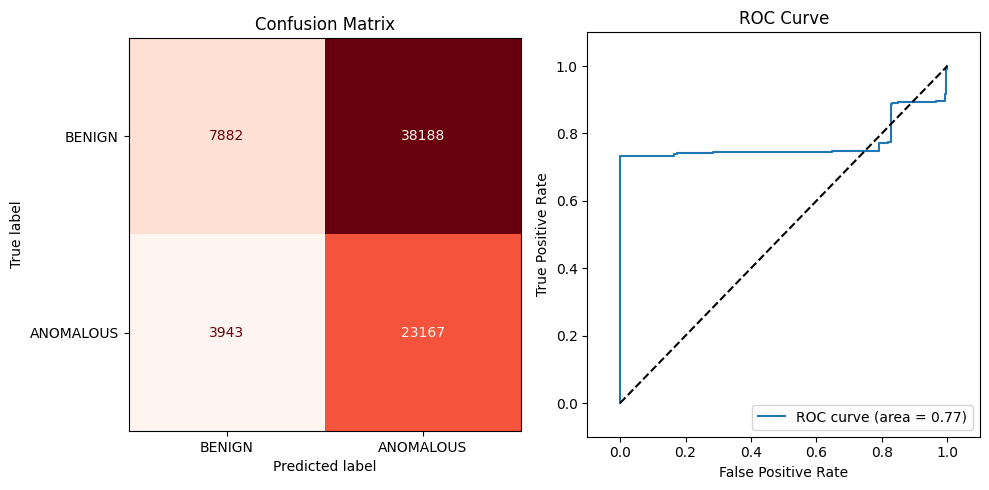

In [7]:
# 6. Evaluate with tcpdump data
print("\nStep 6: Evaluate with tcpdump data")
if os.path.exists(tcpdump_pkl_file_name):
    print(f"Loading dataframe from {tcpdump_pkl_file_name}")
    tcpdump_dataframe = pd.read_pickle(tcpdump_pkl_file_name)
else:
    print(f"Creating dataframe from pcap files and saving to {tcpdump_pkl_file_name}")
    tcpdump_dataframe = DataProcessor.get_dataframe(file_paths=tcpdump_file_paths)
    tcpdump_dataframe.to_pickle(tcpdump_pkl_file_name)

# Add new featueres:
print("Adding new features to the dataframe...")
tcpdump_dataframe = DataProcessor.add_new_features(tcpdump_dataframe)

# Drop object columns and handle categorical data
print("Dropping object columns and handle encoding categorical data...")
tcpdump_df_without_object, available_categorical = DataProcessor.drop_object_columns(
            tcpdump_dataframe, encode_categorical=encode_categorical
        )
# Split into features and labels
print("Splitting data into features (X) and labels (y)...")
X_tcpdump, y_tcpdump = DataProcessor.split_to_X_y(tcpdump_df_without_object)

print("Cleaning data...")
DataProcessor.clean_data(X_tcpdump)

print(f"X_tcpdump.shape: {X_tcpdump.shape}")
print(f"y_tcpdump.shape: {y_tcpdump.shape}")

print("Handling categorical encoding...")
print(f"Available categorical features: {available_categorical}")
print(f"Use categorical_encoder: {categorical_encoder}")
X_tcpdump, _, categorical_encoder = (
    DataProcessor.one_hot_encode_categorical(
        X_tcpdump, None, available_categorical, categorical_encoder
    )
)
print(f"X_tcpdump.shape: {X_tcpdump.shape}")

if scaled and scaler is not None:
    print(f"Use MinMaxScaler instance: {scaler}")
    X_tcpdump = pd.DataFrame(
        scaler.transform(X_tcpdump),
        columns=X_tcpdump.columns,
        index=X_tcpdump.index,
    )

y_tcpdump = y_tcpdump.map(lambda x: 1 if x == "benign" else -1)

# Feature selection
print("Feature selection:")
X_tcpdump_optimal = X_tcpdump[optimal_features_list]

print(f"X_tcpdump_optimal.shape: {X_tcpdump_optimal.shape}")
print(f"y_tcpdump.shape: {y_tcpdump.shape}")

evaluate_model(rf, X_tcpdump_optimal, y_tcpdump, with_numpy=True)


Step 7: Interpretation with SHAP


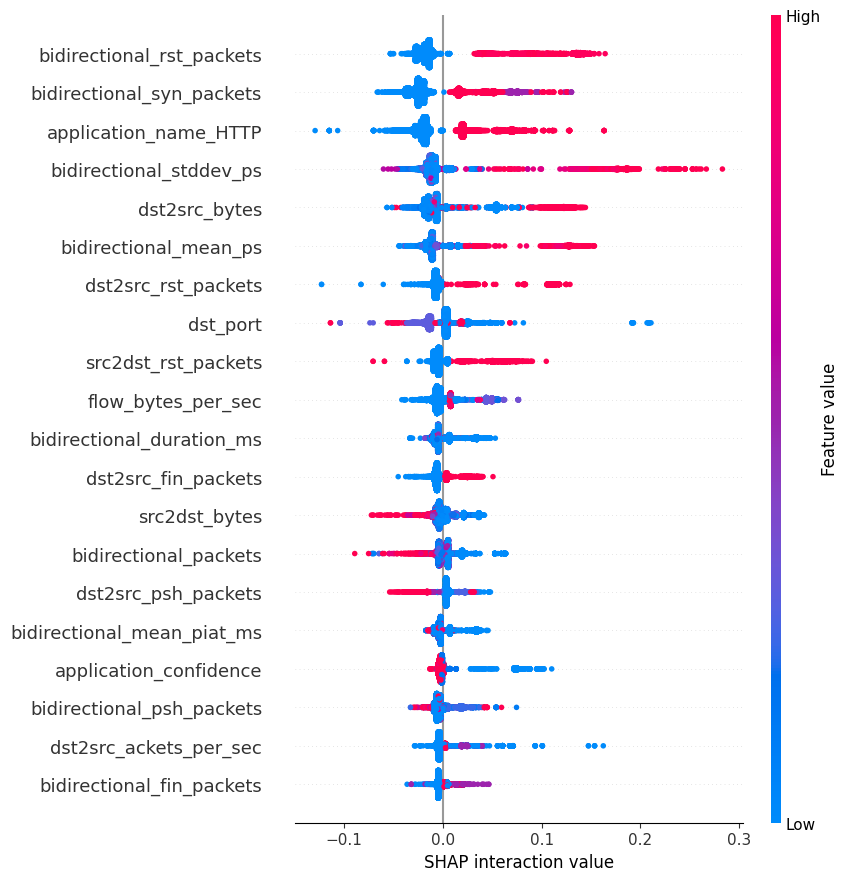

In [8]:
# 7. Interpretation with SHAP
shap_enabled = True
if shap_enabled:
    print("\nStep 7: Interpretation with SHAP")
    explainer = shap.TreeExplainer(rf)
    X_test_optimal_sampled = X_test_optimal.sample(n=10000, random_state=random_state) 
    shap_values = explainer.shap_values(X_test_optimal_sampled)

    plt.figure(figsize=(14, 8)) 

    if len(shap_values.shape) == 3:
        main_effects = shap_values[:, :, :-1].sum(axis=2)
        shap.summary_plot(main_effects, X_test_optimal_sampled, feature_names=optimal_features_list, show=False)
    else:
        shap.summary_plot(shap_values, X_test_optimal_sampled, feature_names=optimal_features_list, show=False)

    plt.tight_layout()
    plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.1)
    plt.xlabel('SHAP interaction value', fontsize=12)
    plt.show()

In [9]:
# 8. Feature Importance
print("\nStep 8: Feature Importance")
with pd.option_context('display.max_rows', None):
    print(importance_df.head(len(optimal_features_list)))


Step 8: Feature Importance
                           feature  importance
12         bidirectional_stddev_ps    0.084748
33       bidirectional_rst_packets    0.083522
9                    dst2src_bytes    0.071479
11           bidirectional_mean_ps    0.050756
1                         dst_port    0.050579
43             dst2src_rst_packets    0.038378
46          application_confidence    0.032124
8                    src2dst_bytes    0.031562
7            bidirectional_packets    0.030574
47              flow_bytes_per_sec    0.029129
281       application_name_Unknown    0.027939
32       bidirectional_psh_packets    0.027555
37             src2dst_rst_packets    0.027199
137          application_name_HTTP    0.027083
217           application_name_TLS    0.026072
28       bidirectional_syn_packets    0.025665
49         src2dst_packets_per_sec    0.021941
16                  dst2src_min_ps    0.020947
2                         protocol    0.019319
15               src2dst_stddev_

In [11]:
model_dir = os.path.join(project_root, 'models', 'rf')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created model directory: {model_dir}")

# save the model
model_file_name = os.path.join(model_dir, "model.pkl")
print(f"Saving the model to {model_file_name}")
joblib.dump(rf, model_file_name)
print("Model saved successfully.")

# save the encoder
encoder_file_name = os.path.join(model_dir, "encoder.pkl")
print(f"Saving the encoder to {encoder_file_name}")
joblib.dump(categorical_encoder, encoder_file_name)
print("Encoder saved successfully.")

# save the importance_df
importance_file_name = os.path.join(model_dir, "importance_df.pkl")
print(f"Saving the importance DataFrame to {importance_file_name}")
importance_df.to_pickle(importance_file_name)
print("Importance DataFrame saved successfully.")

# save the optimal_features_list
optimal_features_file_name = os.path.join(model_dir, "optimal_features_list.pkl")
print(f"Saving the optimal features list to {optimal_features_file_name}")
joblib.dump(optimal_features_list, optimal_features_file_name)
print("Optimal features list saved successfully.")

Created model directory: /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/models/rf
Saving the model to /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/models/rf/model.pkl
Model saved successfully.
Saving the encoder to /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/models/rf/encoder.pkl
Encoder saved successfully.
Saving the importance DataFrame to /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/models/rf/importance_df.pkl
Importance DataFrame saved successfully.
Saving the optimal features list to /Users/seu/Library/CloudStorage/Dropbox/Docs/Study/Weiterbildung/DBS/Kurse/Projektarbeit/DS/repo/models/rf/optimal_features_list.pkl
Optimal features list saved successfully.
